In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%aimport beanmachine.ppl

In [3]:
%autoreload

# Follow Up To N1660040

Run against https://github.com/feynmanliang/beanmachine/commit/70c76adcabf4a54f275a7d06a23ea257a9b1cf50


In [4]:
import torch.distributions as dist

N = 200
X = dist.Normal(0, 1).expand([N, 1]).sample()
true_beta_1 = 2.0
true_beta_0 = 5.0
true_epsilon = 1.0
Y = dist.Normal(true_beta_1 * X + true_beta_0, true_epsilon).sample()

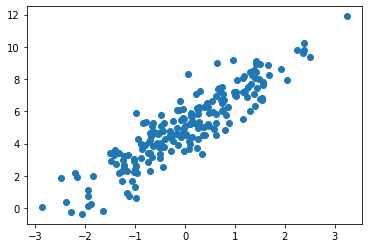

In [5]:
import matplotlib.pyplot as plt

plt.scatter(X, Y)


## MLE Inference

Convert all priors to uninformatives (`Flat`s) so that only likelihood factors are present

In [6]:
import beanmachine.ppl as bm
from beanmachine.ppl.distributions import Flat, Unit, Delta

class LinearRegressionFreq:
    @bm.random_variable
    def sigma_beta_1(self):
        return Flat()

    @bm.random_variable
    def beta_1(self):
        return Flat()

    @bm.random_variable
    def beta_0(self):
        return Flat()

    @bm.random_variable
    def epsilon(self):
        return Flat()

    @bm.random_variable
    def y(self, X):
        return dist.Normal(self.beta_1() * X + self.beta_0(), torch.nn.functional.softplus(self.epsilon()))

Perform VI using `Delta`s to obtain point estimates maximizing ELBO $\propto$ likelihood

In [7]:
import torch
import torch.optim as optim

model = LinearRegressionFreq()

@bm.param
def phi():
    return torch.tensor([0, 0, 1]).float()

@bm.random_variable
def q_beta_0():
    return Delta(phi()[0])

@bm.random_variable
def q_beta_1():
    return Delta(phi()[1])

@bm.random_variable
def q_eps():
    return Delta(phi()[2])


world_mle = bm.VariationalInfer(
    {
        model.beta_0(): q_beta_0(),
        model.beta_1(): q_beta_1(),
        model.epsilon(): q_eps(),
    },
    observations={model.y(X): Y},
    optimizer=lambda params: optim.Adam(params, lr=1e-2)
).infer(
    num_steps=1000,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
import torch.nn.functional as F

print([(rvid, world_mle.get_variable(rvid()).value) for rvid in (q_beta_0, q_beta_1,)])
print([(rvid, F.softplus(world_mle.get_variable(rvid()).value)) for rvid in (q_eps,)])

[(<function q_beta_0 at 0x7f8c7e827940>, tensor(4.4322, requires_grad=True)), (<function q_beta_1 at 0x7f8c7e827a60>, tensor(1.9348, requires_grad=True))]
[(<function q_eps at 0x7f8c7e827b80>, tensor(1.9952, grad_fn=<SoftplusBackward0>))]


The MLE estimates are close to $\beta_0 = 5.0$, $\beta_1 = 2.0$, $\epsilon = 1.0$, which agrees with the theory on consistency of MLEs.

In [9]:
print(true_beta_0, true_beta_1, true_epsilon)

5.0 2.0 1.0


## MAP Inference

Keep priors around so the world `log_prob` is proportional to the posterior. VI with `Delta`s effectively performs MAP.

In [10]:
%autoreload

In [11]:
import torch
import torch.distributions as dist
import torch.optim as optim

class LinearRegressionBayes:
    @bm.random_variable
    def sigma_beta_1(self):
        return dist.Gamma(1, 1)

    @bm.random_variable
    def beta_1(self):
        return dist.Normal(0, self.sigma_beta_1())

    @bm.random_variable
    def beta_0(self):
        return dist.Normal(0,  10)

    @bm.random_variable
    def epsilon(self):
        return dist.Gamma(1, 1)

    @bm.random_variable
    def y(self, X):
        return dist.Independent(
            dist.Normal(self.beta_1() * X + self.beta_0(), self.epsilon()),
            0)


model = LinearRegressionBayes()

@bm.param
def phi():
    return torch.tensor([0, 0, 1]).float()

@bm.random_variable
def q_beta_0():
    return Delta(phi()[0])

@bm.random_variable
def q_beta_1():
    return Delta(phi()[1])

@bm.random_variable
def q_eps():
    return Delta(phi()[2])


world_map = bm.VariationalInfer(
    {
        model.beta_0(): q_beta_0(),
        model.beta_1(): q_beta_1(),
        model.epsilon(): q_eps(),
    },
    observations={model.y(X): Y},
    optimizer=lambda params: optim.Adam(params, lr=1e-2),
).infer(
    num_steps=1000,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
print([(rvid, world_map.get_variable(rvid()).value) for rvid in (q_beta_0, q_beta_1,)])
print([(rvid, F.softplus(world_map.get_variable(rvid()).value)) for rvid in (q_eps,)])

[(<function q_beta_0 at 0x7f8c7e7e4160>, tensor(3.8962, requires_grad=True)), (<function q_beta_1 at 0x7f8c7e7e4280>, tensor(-0.0038, requires_grad=True))]
[(<function q_eps at 0x7f8c7e7e43a0>, tensor(2.6429, grad_fn=<SoftplusBackward0>))]


In [13]:
print(true_beta_0, true_beta_1, true_epsilon)

5.0 2.0 1.0


The resulting MAP estimates are ``shrunken'' towards the origin, agreeing with a shrinkage view of Bayesian priors.

## SVI with a Bayesian Linear Regression NNet

Next, consider a variational model more complicated than `Delta`s

In [14]:
%autoreload

The following sets the guide $q(x)$ to be a simple linear neural network.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class LinearRegressionNNet(nn.Module):
    def __init__(self):
        super(LinearRegressionNNet, self).__init__()

    @bm.param
    def mu(self):
        return torch.zeros(1)

    @bm.random_variable
    def q_mu(self):
        return Delta(self.mu())

    @bm.param
    def scale(self):
        return torch.ones(1)

    @bm.random_variable
    def q_scale(self):
        return Delta(self.scale())

    @bm.random_variable
    def mu_rv(self):
        return Flat()  # MLE, no priors

    @bm.random_variable
    def scale_rv(self):
        return Flat()  # MLE, no priors

    @bm.random_variable
    def forward(self, x):
        return dist.Independent(dist.Normal(
            loc=self.mu_rv() * X,
            scale=F.softplus(self.scale_rv()),
        ), 1)

net = LinearRegressionNNet()

world = bm.VariationalInfer(
    {
        net.mu_rv(): net.q_mu(),
        net.scale_rv(): net.q_scale(),
    },
    {
        net.forward(X): Y,
    },
    optimizer=lambda params: optim.Adam(params, lr=1e-1)
).infer(
    num_steps=1000,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
world.get_param(net.mu()), F.softplus(world.get_param(net.scale()))

(tensor([1.9932], requires_grad=True),
 tensor([5.1500], grad_fn=<SoftplusBackward0>))

The (without intercept) least-squares estimate of $\mu$ coincides with that obtained here by MLE; unsurprising as LSE is the MLE for Gaussian noise

In [18]:
torch.pinverse(X) @ Y

tensor([[1.9932]])

The `Delta` guide to a `Flat` prior seems redundant to `param`; can we make things more ergonomic?

It turns out yes, if you (confusingly) use the same RV for the model and guide (the two cancel out in the density ratio) and furthermore observe on the same RV (so that the likelihood term is added to the `world.log_prob`). Then, optimization of variational `param`s literally corresponds to MLE.

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class LinearRegressionNNet(nn.Module):
    def __init__(self):
        super(LinearRegressionNNet, self).__init__()

    @bm.param
    def mu(self):
        return torch.zeros(1)

    @bm.param
    def scale(self):
        return torch.ones(1)
    @bm.random_variable
    def forward(self, x):
        return dist.Independent(dist.Normal(
            loc=self.mu() * X,
            scale=F.softplus(self.scale()),
        ), 1)

net = LinearRegressionNNet()

world = bm.VariationalInfer(
    {
        net.forward(X): net.forward(X),
    },
    {
        net.forward(X): Y,
    },
    optimizer=lambda params: optim.Adam(params, lr=1e-1)
).infer(
    num_steps=1000,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
world.get_param(net.mu()), F.softplus(world.get_param(net.scale()))

(tensor([1.9932], requires_grad=True),
 tensor([5.1500], grad_fn=<SoftplusBackward0>))

Removing the `Flat`s and `Delta`s from an earlier MLE:

In [23]:
import torch
import torch.optim as optim

import beanmachine.ppl as bm
from beanmachine.ppl.distributions import Flat, Unit, Delta

class LinearRegressionFreqSlim:
    @bm.param
    def beta_1(self):
        return torch.zeros(1)

    @bm.param
    def beta_0(self):
        return torch.zeros(1)

    @bm.param
    def epsilon(self):
        return torch.ones(1)

    @bm.random_variable
    def y(self, X):
        return dist.Normal(self.beta_1() * X + self.beta_0(), torch.nn.functional.softplus(self.epsilon()))

model = LinearRegressionFreqSlim()

world = bm.VariationalInfer(
    {
        model.y(X): model.y(X),
    },
    observations={model.y(X): Y},
    optimizer=lambda params: optim.Adam(params, lr=1e-2)
).infer(
    num_steps=1000,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [24]:
print([(rvid, world.get_param(rvid())) for rvid in (model.beta_0, model.beta_1,)])
print([(rvid, F.softplus(world.get_param(rvid()))) for rvid in (model.epsilon,)])

[(<bound method LinearRegressionFreqSlim.beta_0 of <__main__.LinearRegressionFreqSlim object at 0x7f8c7d514610>>, tensor([4.4322], requires_grad=True)), (<bound method LinearRegressionFreqSlim.beta_1 of <__main__.LinearRegressionFreqSlim object at 0x7f8c7d514610>>, tensor([1.9348], requires_grad=True))]
[(<bound method LinearRegressionFreqSlim.epsilon of <__main__.LinearRegressionFreqSlim object at 0x7f8c7d514610>>, tensor([1.9952], grad_fn=<SoftplusBackward0>))]


In [25]:
print(true_beta_0, true_beta_1, true_epsilon)

5.0 2.0 1.0
